In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

In [5]:
crimes=pd.read_csv('chicago_crimes_2012_to_2017.csv')

In [7]:
crimes.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [8]:
crimes.drop(['Unnamed: 0', 'Case Number', 'IUCR','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location'], inplace=True, axis=1)

As we can tell from the first few rows, we have several columns that will help us answer our questions. We will use the 'Date' column to explore temporal patterns, 'Primary Type' and 'Location Description' to investigate their relationship with time (month of the year, time of the day, hour of the day, .. etc). Later we will use geolocation to map out safe spots (and times) in the city.

In [9]:
#Let us check the column name now 
crimes.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,District,X Coordinate,Y Coordinate,Latitude,Longitude
0,10508693,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,10.0,1154907.0,1893681.0,41.864073,-87.706819
1,10508695,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,3.0,1183066.0,1864330.0,41.782922,-87.604363
2,10508697,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,15.0,1140789.0,1904819.0,41.894908,-87.758372
3,10508698,05/03/2016 10:10:00 PM,049XX W FULTON ST,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,1143223.0,1901475.0,41.885687,-87.749516
4,10508699,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,THEFT,$500 AND UNDER,RESIDENCE,False,True,15.0,1139890.0,1901675.0,41.886297,-87.761751


Sweet. Because we are dealing with dates, we need to convert the 'Date' column into a date format that is understandable by Python (and pandas).

In [10]:
# convert dates to pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)

How many records we have and how many features for each record?

In [11]:
#Number of records of records X # of features
crimes.shape

(1456714, 13)

Let's check if we are dealing with the right type of columns

In [12]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1456714 entries, 2016-05-03 23:40:00 to 2016-05-03 23:38:00
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   ID                    1456714 non-null  int64         
 1   Date                  1456714 non-null  datetime64[ns]
 2   Block                 1456714 non-null  object        
 3   Primary Type          1456714 non-null  object        
 4   Description           1456714 non-null  object        
 5   Location Description  1455056 non-null  object        
 6   Arrest                1456714 non-null  bool          
 7   Domestic              1456714 non-null  bool          
 8   District              1456713 non-null  float64       
 9   X Coordinate          1419631 non-null  float64       
 10  Y Coordinate          1419631 non-null  float64       
 11  Latitude              1419631 non-null  float64       
 12  Longitude

As 'Location Description', 'Description' and 'Primary Type' columns are actually categorical columns (or factors in R), we will only keep the most frequent categories and then cast them to a categorical type.

In [13]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'
#crimes.loc[crimes['Primary Type'].isin(type_to_change) , crimes.columns=='Primary Type'] = 'OTHER'

In [14]:
# we convert those 3 columns into 'Categorical' types -- works like 'factor' in R
crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

Now that we are done with cleaning let us start to explore our datasets

## Exploration and Visualization

Let us begin by some generic queries, like how many records we have for each month ?

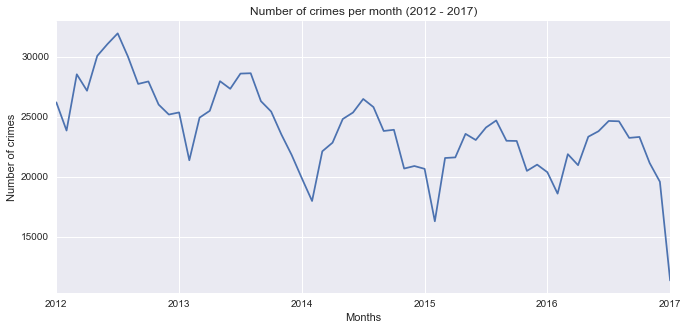

In [16]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2012 - 2017)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

This chart shows a clear "periodic" pattern in the crimes over many years. I guess this very periodic pattern is an essential part of why crime a very predictable activity!.

Before we take a deeper look into how other features could mediate such temporal consistency, I first want to answer our first question: How crime has changed over the years? is it decreasing? Let's have a look at what we have (from 2012 to 2017 for now).

In a previous chart, we already looked at the number of weekly crime records. Although it may not be very clear from the previous chart how crime have changed over the years, it still gives somehow similar numbers between 2015 and 2016. Here, we will take a finer scale to get the visualization right. I decided to look at the rolling sum of crimes of the past year. The idea is, for each day, we calculate the sum of crimes of the past year. If this rolling sum is decreasing, then we know for sure that crime rates have been decreasing during that year. On the other hand, if the rolling sum stays the same during a given year, then we can conclude that crime rates stayed the same.

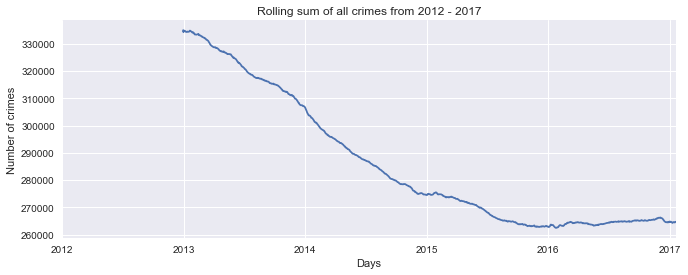

In [17]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2012 - 2017')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

We see the line decreasing from 2013 up to some point around 2016 after which it stays around the same number of crimes. This all means that 2016 is really no better than 2015, but both years show a much better crime record (in total) than the previous years.

But..

could this figure be too good to be true?

Let's separate crimes by type and see

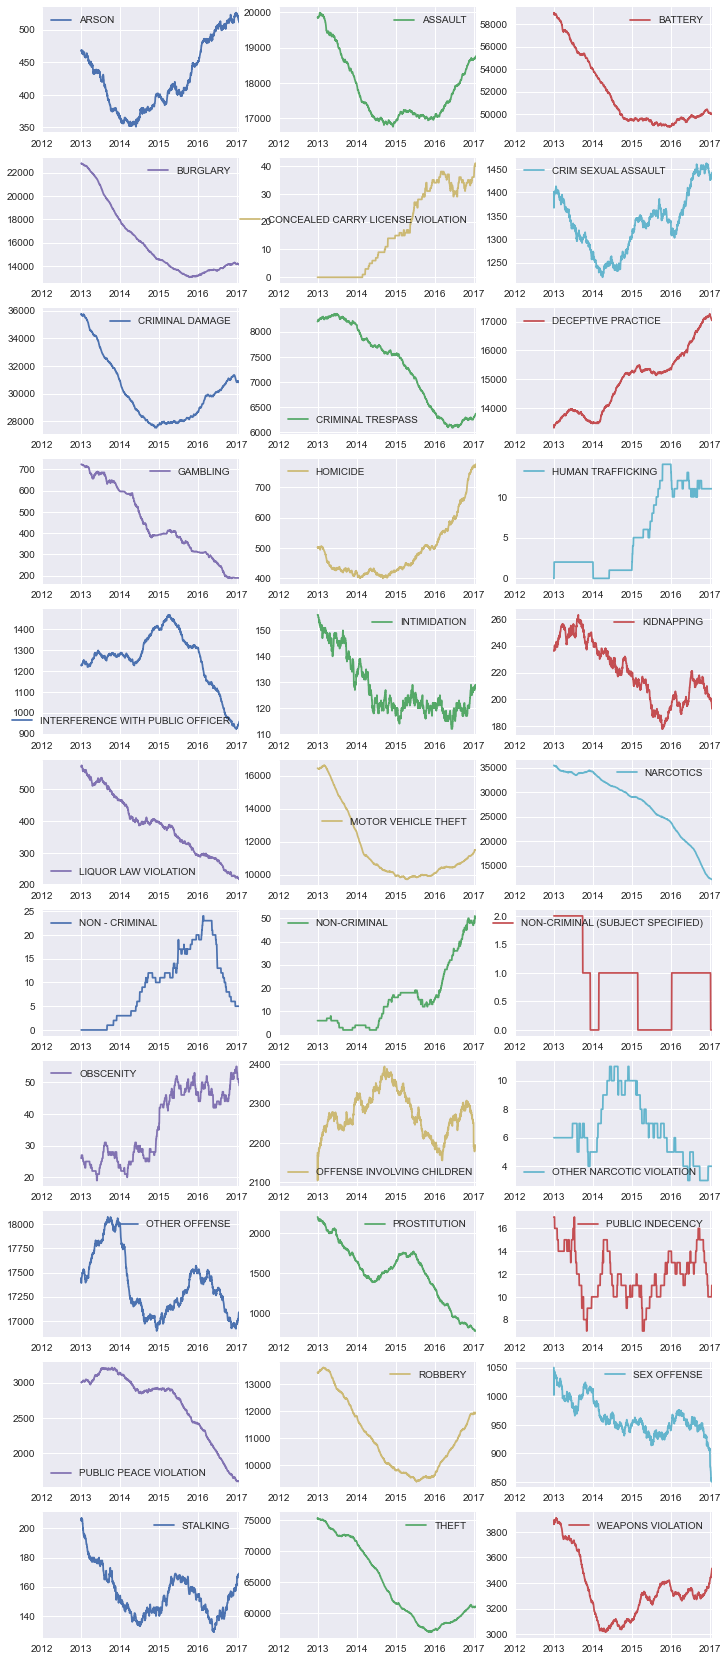

In [18]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

Hmmm. Lots of things can be said. I have stared at this plot myself for long because I was really excited to see the first figure and hoped it reflected an average trend toward decreasing crimes. But it is not the case. Some crime types are actually increasing all along like homicide and deceptive practice. Other types started to increase slightly before 2016 like theft, robbery and stalking (which may be the reason behind the trend we saw earlier).

### Let us have a general view of crime records by time, type and location

Not all crimes are the same. Some crimes types are more likely to occur than other types depending on the place and time. In this section, we will see how crimes differ between different places at different times.

The first thing we are going to look at is if there is a difference in the number of crimes during specific days of the week. Are there more crimes during weekdays or weekend?

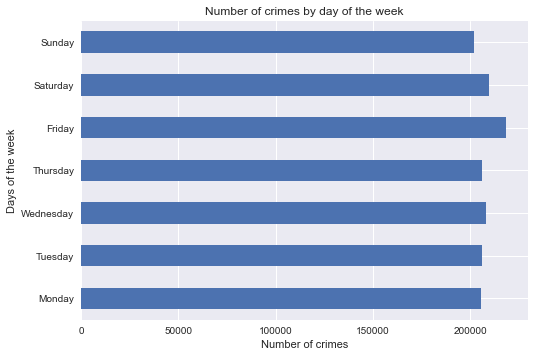

In [19]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

I don't really see something is different between days of the week. Maybe Friday has higher number of crime than other days, but this is still based on the counts and we are not really sure of it means it is always like this.

Now Let's look at crimes per month and see if certain months show more crimes than others.

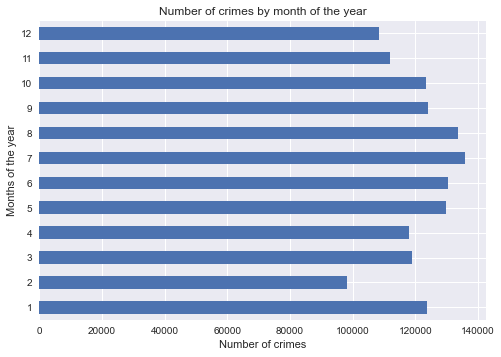

In [20]:
crimes.groupby([crimes.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

Crimes rates seem to peak at summer months!

Let's have a look at the distribution of crime by their types, which crimes are most common among the top 20 most frequent crime types ?

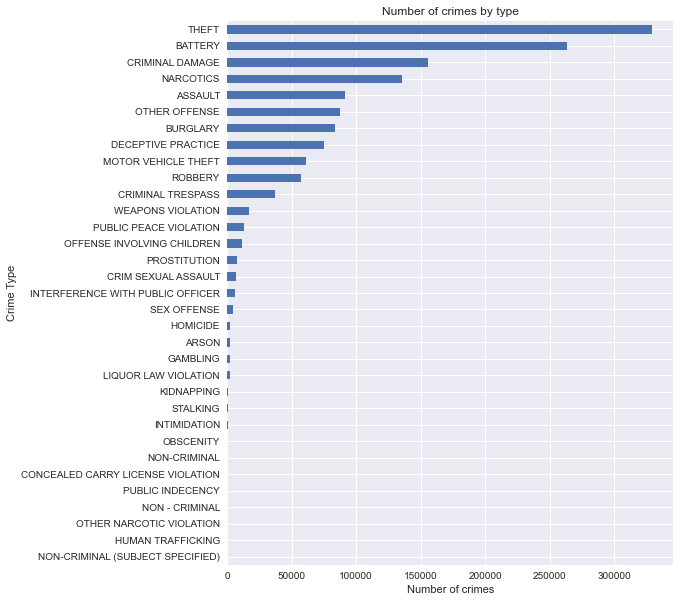

In [23]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

Now for crime location

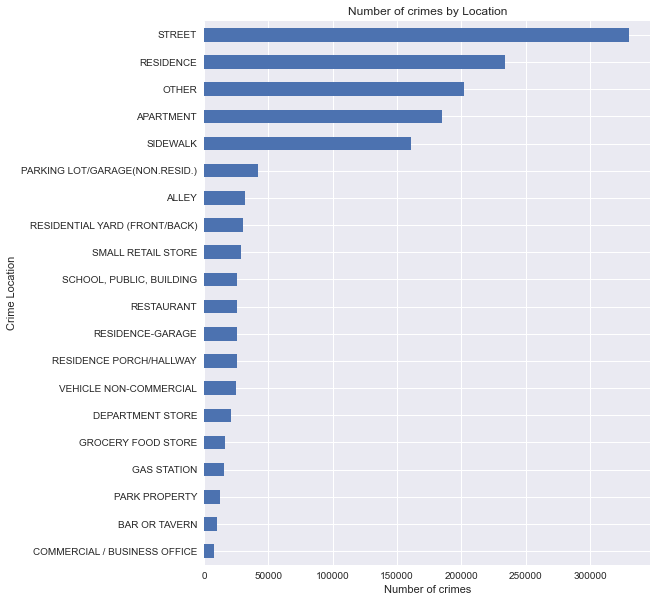

In [24]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

Temporal analysis of crime rates by type and location
Let's use pandas pivot tables to see more
I am not so excited by the charts so far. They are boring. They do not show me interesting things. It only felt like they make sense. In this section, things are way different. We will directly address the second question in the introduction.

Not all crimes are the same. Some crimes types are more likely to occur than other types depending on the place and time. In this section, we will see how crimes differ between different places at different times.

After seeing the base rates of each crime location and type, we will now assume that all crime types (and locations) have the same frequency or, in other words, they are all equal overall. We are interested in detecting how a specific crime type is different across all days of the week or hours of the day.

Is theft or burglary is more likely to occur at a weekday compared to a weekend? Are they more likely to happen in the morning vs evening or late night ? are they more likely to occur in a street vs a bar?



In [28]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Before we go on, let me explain how we got those heatmaps. For each set of those pots, I re-scaled counts of crime records in each hour within each crime type to be z-scaled (to have a mean of zero and a unit standard deviation). So it is a "within-type/ across-hours" scaling that aims to show differences between frequencies of crimes at different hours. All types have the save "average" of crime counts, but not all hours have the same average. So a negative value indicate a lower frequency while a positive value indicate a higher frequency for that crime to occur in a particular hour.

First, let's see if there are "day crimes vs night crimes" thing. As you can see, some crimes have their peaks during the early morning (upper part of the heatmap), other crimes peak during the day (mid-part of the heatmap) and the final group of crimes peak at night (lower part of the heatmap

Where a certain crime type is most likely to happen?
In this section, we hope to answer another type of questions: for a given crime (like theft or sexual assault), what is the most likely location for this crime to happen? In this analysis, as with the previous ones, we take each crime type and re-normalize its location frequency to be between zero and one. This way, we can look at the top frequent locations of each crime type (darker red reflect a more frequent location).

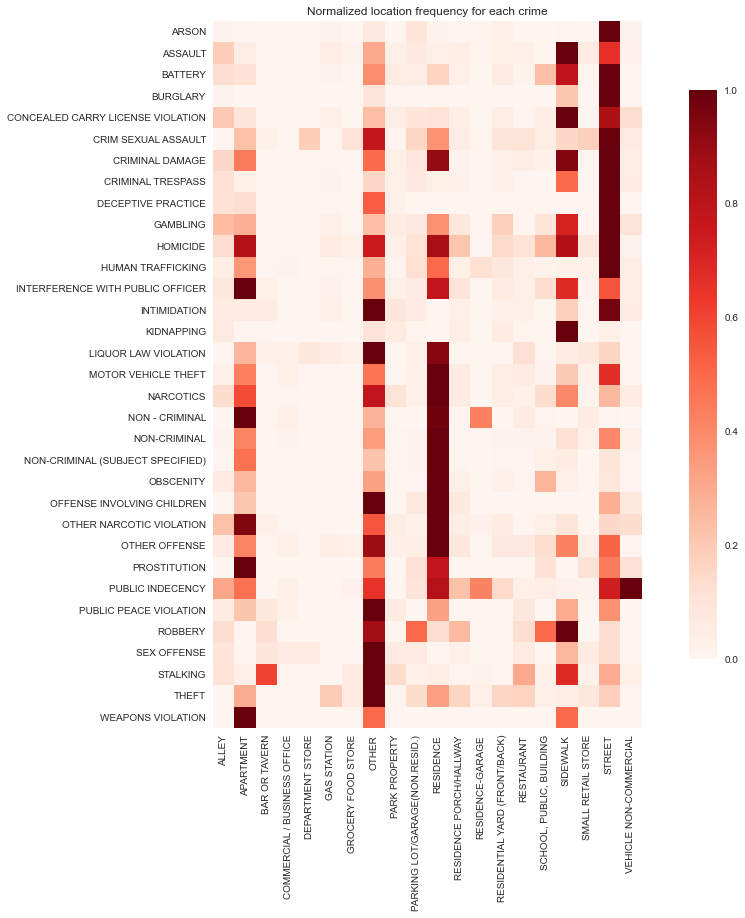

In [36]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

Well, it appears that most crimes occur at either apartments, residence, sidewalks, streets or 'other'. There are few notable exceptions here and there but those places are very frequent. This heatmap got me thinking that I probably should've used more than 20 categories. But that is "left as an exercise for the reader" ;)

In [37]:
crimes.iloc[(crimes[['Longitude']].values < -88.0).flatten(), crimes.columns=='Longitude'] = 0.0
crimes.iloc[(crimes[['Longitude']].values > -87.5).flatten(), crimes.columns=='Longitude'] = 0.0
crimes.iloc[(crimes[['Latitude']].values < 41.60).flatten(),  crimes.columns=='Latitude'] = 0.0
crimes.iloc[(crimes[['Latitude']].values > 42.05).flatten(),  crimes.columns=='Latitude'] = 0.0
crimes.replace({'Latitude': 0.0, 'Longitude': 0.0}, np.nan, inplace=True)
crimes.dropna(inplace=True)

C:\Users\Salam Basit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Salam Basit\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Salam Basit\anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.005 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Salam Basit\anaconda3\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.

ValueError: If using all scalar values, you must pass an index

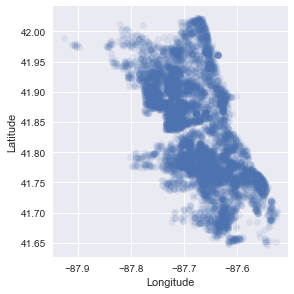

In [40]:
crimes_new = crimes[(crimes['Primary Type'] == 'SEX OFFENSE') | (crimes['Primary Type'] == 'HOMICIDE') | (crimes['Primary Type'] == 'ARSON')]
ax = sns.lmplot('Longitude', 'Latitude',
                data= crimes_new[['Longitude','Latitude']],
                fit_reg=False,
                size=4, 
                scatter_kws={'alpha':.1})
ax = sns.kdeplot(crimes_new[['Longitude','Latitude']],
                 cmap="jet", 
                 bw=.005,
                 #n_levels=10,
                 cbar=True, 
                 shade=False, 
                 shade_lowest=False)
ax.set_xlim(-87.9,-87.5)
ax.set_ylim(41.60,42.05)
#ax.set_axis_off()

In [41]:
crime_types = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT', 'BURGLARY', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'ROBBERY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN', 'PROSTITUTION', 'CRIM SEXUAL ASSAULT', 'INTERFERENCE WITH PUBLIC OFFICER', 'SEX OFFENSE', 'HOMICIDE', 'ARSON', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'KIDNAPPING', 'STALKING', 'INTIMIDATION']

In [45]:
from numpy.linalg import svd


class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like
      Two-way contingency table. If `ct` is a pandas DataFrame object,
      the index and column values are used for plotting.
    Notes
    -----
    The implementation follows that presented in 'Correspondence
    Analysis in R, with Two- and Three-dimensional Graphics: The ca
    Package,' Journal of Statistical Software, May 2007, Volume 20,
    Issue 3.
    """

    def __init__(self, ct):
        self.rows = ct.index.values if hasattr(ct, 'index') else None
        self.cols = ct.columns.values if hasattr(ct, 'columns') else None
        
        # contingency table
        N = np.matrix(ct, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        S = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(S, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of rows
        F = D_r_rsq * U * D_a

        # principal coordinates of columns
        G = D_c_rsq * V * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns
        Y = D_c_rsq * V

        # the total variance of the data matrix
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])

        self.F = F.A
        self.G = G.A
        self.X = X.A
        self.Y = Y.A
        self.inertia = inertia
        self.eigenvals = np.diag(D_a)**2

    def plot(self):
        """Plot the first and second dimensions."""
        xmin, xmax = None, None
        ymin, ymax = None, None
        if self.rows is not None:
            for i, t in enumerate(self.rows):
                x, y = self.F[i,0], self.F[i,1]
                plt.text(x, y, t, va='center', ha='center', color='r')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.F[:, 0], self.F[:, 1], 'ro')

        if self.cols is not None:
            for i, t in enumerate(self.cols):
                x, y = self.G[i,0], self.G[i,1]
                plt.text(x, y, t, va='center', ha='center', color='b')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.G[:, 0], self.G[:, 1], 'bs')

        if xmin and xmax:
            pad = (xmax - xmin) * 0.1
            plt.xlim(xmin - pad, xmax + pad)
        if ymin and ymax:
            pad = (ymax - ymin) * 0.1
            plt.ylim(ymin - pad, ymax + pad)

        plt.grid()
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

    def scree_diagram(self, perc=True, *args, **kwargs):
        """Plot the scree diagram."""
        eigenvals = self.eigenvals
        xs = np.arange(1, eigenvals.size + 1, 1)
        ys = 100. * eigenvals / eigenvals.sum() if perc else eigenvals
        plt.plot(xs, ys, *args, **kwargs)
        plt.xlabel('Dimension')
        plt.ylabel('Eigenvalue' + (' [%]' if perc else ''))

In [50]:
ctypexdistrict = crimes.pivot_table(values='ID', index='Primary Type', columns='District', aggfunc=np.size).fillna(0)
ctypexlocation = crimes.pivot_table(values='ID', index='Primary Type', columns='Location Description', aggfunc=np.size).fillna(0)
ctypexhour = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
ctypexmonth = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.month, aggfunc=np.size).fillna(0)
ctypexyear = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.year, aggfunc=np.size).fillna(0)
ctypexdayofweek = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)

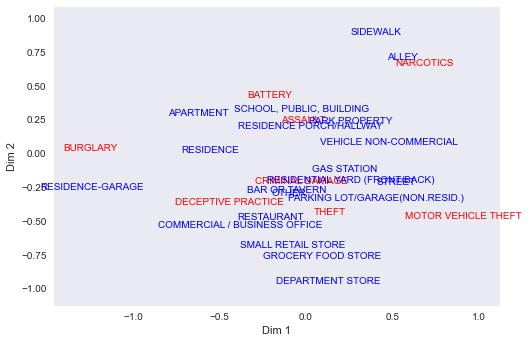

In [51]:
ctypes_short = crime_types[:8]
ca = CA(ctypexlocation.loc[ctypes_short])

plt.figure(100)
ca.plot()